#### Funcitons & Imports

In [3]:
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import unwrap_phase
from matplotlib.colors import hsv_to_rgb
from numpy.polynomial import chebyshev as cheb
import os
from OAH_refocus import *
import matplotlib
import astropy.io.fits as pyfits

from OAH_refocus import *
import time
import sys
import argparse
import glob
import csv
import matplotlib
import math
from scipy.optimize import curve_fit
from fitfunctions import gaussmod, tfmod, bimodalmod, tfaxialmod, gaussmod_OAH, tfmod_OAH, bimodalmod_OAH
from scipy.special import zeta
from scipy.signal import savgol_filter
import os
import cv2
from PIL import Image

import OAH_functions as f1
from OAHDEV_functions import *

display(HTML("<style>.container { width:90% !important; }</style>"))

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
%matplotlib notebook 

In [4]:
# HI processing - custum needed for the PCA
def HI_refocus_PCA(date, shot, dz_focus=0.000, max_nums='None'):
    pix_size = 5.6e-6
    k0 = 2 * np.pi / 589e-9
    save_path = f"/home/bec_lab/Desktop/imgs/SOAH/PCA_Analysis/data/{date}_{shot}_PCA.npy"

    if os.path.exists(save_path):
        print("Already exists, loading now.")
        return np.load(save_path, allow_pickle=True)

    # Setup paths and read FITS files once
    path = f'/storage/data/{date}/{str(shot).zfill(4)}/'
    xmin, xmax, zmin, zmax = 1, -1, 1, -1
    atoms_raw = pyfits.open(path + '0.fits')[0].data.astype(float)[:, xmin:xmax, zmin:zmax]
    flats_raw = pyfits.open(path + '1.fits')[0].data.astype(float)[:, xmin:xmax, zmin:zmax]
    dark = pyfits.open(path + '2.fits')[0].data.astype(float).mean(axis=0)[xmin:xmax, zmin:zmax]

    
    if max_nums == "None":
        num_of_nums = atoms_raw.shape[0]
    else: 
        num_of_nums = max_nums

    print(f"{num_of_nums} images present. Processing...")

    atom_images, blank_images, all_phases = [], [], []

    def process_channel(fft_a, fft_f, shift_z, quad):
        # Cut out sidebands
        qa, _ = f1.box_cutter_pad_ellips(fft_a, quad, 0, 0, edge_x=10, edge_z=80)
        qf, _ = f1.box_cutter_pad_ellips(fft_f, quad, 0, 0, edge_x=10, edge_z=80)
        qa, qf = f1.sizecomp(qa, qf)

        # FFT shift
        qa, qf = np.fft.fftshift(qa), np.fft.fftshift(qf)

        # Refocus
        Nz, Nx = qa.shape
        kx, kz = np.fft.fftfreq(Nx), np.fft.fftfreq(Nz)
        KX, KZ = np.meshgrid(kx, kz)
        phase_ramp = np.exp(-1j * 2 * np.pi * KZ * shift_z)

        fft_kx = np.fft.fftfreq(Nx, d=pix_size)
        fft_ky = np.fft.fftfreq(Nz, d=pix_size)
        fft_k2 = fft_kx[None, :]**2 + fft_ky[:, None]**2
        focus = np.exp(-1j * fft_k2 * dz_focus / (2 * k0))

        filt = focus * phase_ramp
        qa *= filt
        qf *= filt

        # Crop and reconstruct
        inv_a = np.fft.ifft2(qa)[10:-10, 100:-100]
        inv_f = np.fft.ifft2(qf)[10:-10, 100:-100]
        ratio_phase = unwrap_phase(np.angle(inv_a / inv_f))
        ratio_phase -= ratio_phase.mean()
        ratio_phase = normalize(ratio_phase)[0]

        # Clean phase
        a_phase = unwrap_phase(np.angle(RemovePhaseGradient(inv_a)))
        f_phase = unwrap_phase(np.angle(RemovePhaseGradient(inv_f)))
        return a_phase, f_phase, ratio_phase

    for num in range(num_of_nums):
        print(f"{num}/{num_of_nums}")
        atom = f1.squaroid(atoms_raw[num] - dark, width=0.51)
        flat = f1.squaroid(flats_raw[num % len(flats_raw)] - dark, width=0.51)
        fft_atom, fft_flat = np.fft.fft2(atom), np.fft.fft2(flat)

        pol_a, pol_f, pol_phase = [], [], []
        for quad, shift_z in zip(["quad1", "quad2"], [0, -0.48]):
            a, f, p = process_channel(fft_atom.copy(), fft_flat.copy(), shift_z, quad)
            pol_a.append(a)
            pol_f.append(f)
            pol_phase.append(p)

        atom_images.append(pol_a)
        blank_images.append(pol_f)
        all_phases.append(pol_phase)

    result = [np.array(atom_images), np.array(blank_images), np.array(all_phases)]
    np.save(save_path, result)
    return result

def Complex2HSV(z, rmin, rmax, hue_start=90, dphi=360):
    amp = np.clip(np.abs(z), rmin, rmax)
    ph = np.angle(z, deg=True)
    h = (ph / dphi + hue_start/360) % 1
    s = 0.85 * np.ones_like(h)
    v = (amp - rmin) / (rmax - rmin)
    return hsv_to_rgb(np.stack((h, s, v), axis=-1))

def RemovePhaseGradient(image, gradientremovalorder_X=3, gradientremovalorder_Y=2):
    image_unwrapped = unwrap_phase(np.angle(image))
    xdim_, ydim_ = image.shape
    X_axis = np.linspace(-1, 1, xdim_)
    Y_axis = np.linspace(-1, 1, ydim_)
    flat1 = np.mean(image_unwrapped, axis=0)
    flat2 = np.mean(image_unwrapped, axis=1)
    fit1 = cheb.chebfit(Y_axis, flat1, gradientremovalorder_Y)
    fit2 = cheb.chebfit(X_axis, flat2, gradientremovalorder_X)
    fit2[0] = 0
    fiteval = cheb.chebval(Y_axis, fit1) + np.outer(np.ones_like(Y_axis), cheb.chebval(X_axis, fit2)).T
    return np.exp(-1j * fiteval) * image

def get_nr_of_atoms(date, shot):
    fits_path = f'/storage/data/{date}/{str(shot).zfill(4)}/0.fits'
    nr = len(pyfits.open(fits_path)[0].data.astype(float))
    return nr

def get_nr_of_flats(date, shot):
    fits_path = f'/storage/data/{date}/{str(shot).zfill(4)}/1.fits'
    nr = len(pyfits.open(fits_path)[0].data.astype(float))
    return nr

def doPCA(phase_atoms, phase_blank, number_of_images='all'):
    """ Give it an ndim array of the pjhases with atoms and the blank ones. 
    The dimensions for both are (nr_images, polarization_channels, height, width). 
    Returns the matrix decomposition U, S, Vh, as well as VHY - the corresponding image like structure. 
    
    U: holds information on the temporal modes (vertical axis in the stacked array
    S - 
    Vh: spatial modes (basis vectors for pixels)
    
    """
    if number_of_images == "all":
        number_of_images = phase_atoms.shape[0]
        print(number_of_images)
        
    # --- Mask atoms from blank images ---
    noatom_data = phase_blank.copy()
    noatom_data[:,:,20:-20,1000:2000] = 0

    # --- Flatten for SVD ---
    flatstack = noatom_data.reshape((number_of_images, 2, -1))
    flatstack_atoms = phase_atoms.reshape((number_of_images, 2, -1))
    flatstack_reconstruct = phase_blank.reshape((number_of_images, 2, -1))

    stack0 = flatstack[:,0,:]
    stack0A = flatstack_atoms[:,0,:]
    stack0r = flatstack_reconstruct[:,0,:]
    
    stacks = [stack0, stack0A, stack0r]
    
    # --- SVD ---
    U, S, Vh = np.linalg.svd(stack0, full_matrices=False)
    VHY = (np.conj(U.T) @ stack0r)
    VHY = (S[:,None]**-1) * VHY

    # --- Explained variance ---
    for V in range(0, 50, 5):
        f_explained = (S[1:V]**2).sum() / (S[1:]**2).sum()
        print(f"Variance explained by first {V} modes: {f_explained:.2f}")

    return U, S, Vh, VHY, stacks

## Generate Data

In [5]:
shots = [3, 4, 5, 6, 9, 11, 16, 17, 22, 23, 24, 28, 29, 33, 37, 38, 42, 43, 44, 45, 65, 66, 67]
date = 20250507
shot = 66
number_of_images = get_nr_of_atoms(date, shot)
ats, fls, phs = HI_refocus_PCA(date, shot)
U, S, Vh, VHY, stacks = doPCA(ats, fls) # Do the PCA

Already exists, loading now.
200
Variance explained by first 0 modes: 0.00
Variance explained by first 5 modes: 0.72
Variance explained by first 10 modes: 0.76
Variance explained by first 15 modes: 0.79
Variance explained by first 20 modes: 0.80
Variance explained by first 25 modes: 0.81
Variance explained by first 30 modes: 0.82
Variance explained by first 35 modes: 0.83
Variance explained by first 40 modes: 0.83
Variance explained by first 45 modes: 0.84


In [9]:
ats.shape

(200, 2, 78, 2358)

42


<IPython.core.display.Javascript object>


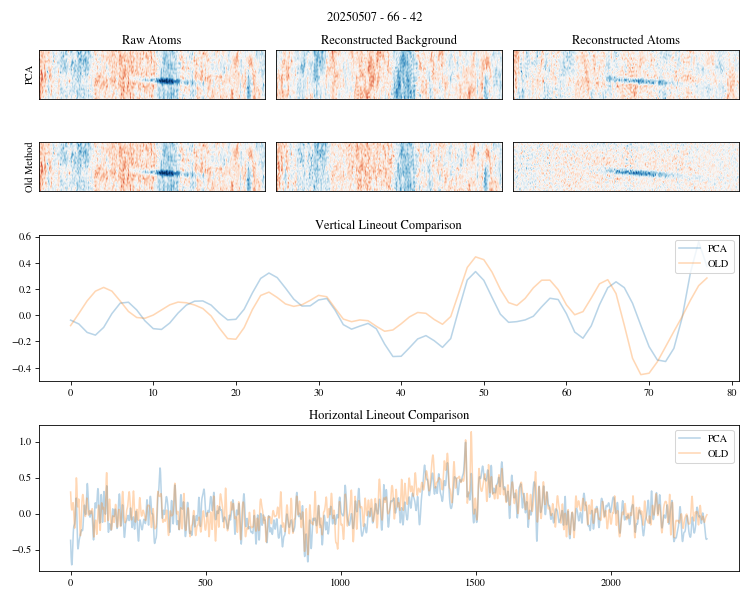

In [10]:
# for t in range(number_of_images):
# --- Compare reconstruction ---
t       = 42      # test image index
pol_ch  = 1       # 0 or 1, for polarization 
V       = 12      # Number of PCA components to kee p
xdim, ydim  = ats.shape[-2:]
print(t)
coeff = Vh[:V] @ stacks[1][t]
sim = coeff @ VHY[:V]
sim = sim.reshape(xdim, ydim)
residual = ats[t, pol_ch] - sim

at_ang = ats[t, pol_ch]
fl_ang = fls[t, pol_ch]
an_ang = phs[t, pol_ch]

# --- Plot ---
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 3, 3])

# PCA
ax01 = fig.add_subplot(gs[0, 0])
ax02 = fig.add_subplot(gs[0, 1], sharex=ax01, sharey=ax01)
ax03 = fig.add_subplot(gs[0, 2], sharex=ax01, sharey=ax01)
# OLD 
ax11 = fig.add_subplot(gs[1, 0], sharex=ax01, sharey=ax01)
ax12 = fig.add_subplot(gs[1, 1], sharex=ax01, sharey=ax01)
ax13 = fig.add_subplot(gs[1, 2], sharex=ax01, sharey=ax01)
# Linecuts
ax4 = fig.add_subplot(gs[2, :])
ax5 = fig.add_subplot(gs[3, :])

ax01.set_title('Raw Atoms')
ax02.set_title('Reconstructed Background')
ax03.set_title('Reconstructed Atoms')
ax01.set_ylabel("PCA")
ax11.set_ylabel("Old Method")

ax01.imshow(  at_ang, vmin=-1, vmax=1, cmap='RdBu', aspect='auto')  # Raw phase
ax02.imshow(     sim, vmin=-1, vmax=1, cmap='RdBu', aspect='auto')  # Reconstructed background
ax03.imshow(residual, vmin=-1, vmax=1, cmap='RdBu', aspect='auto')  # Residual (atoms only)
ax11.imshow(  at_ang, vmin=-1, vmax=1, cmap='RdBu', aspect='auto')  # Raw phase
ax12.imshow(  fl_ang, vmin=-1, vmax=1, cmap='RdBu', aspect='auto')  # Reconstructed background
ax13.imshow(  an_ang, vmin=-1, vmax=1, cmap='RdBu', aspect='auto')  # Old Phase Reconstruction 

# Linecuts
x_line = 1500
y_line = 52
ax4.set_title('Vertical Lineout Comparison')
ax5.set_title('Horizontal Lineout Comparison')

ax4.plot(residual[:, x_line], label='PCA', alpha=0.31, c='C0')
ax4.plot(   an_ang[:,x_line], label='OLD', alpha=0.31, c='C1')
ax5.plot(   residual[y_line], label='PCA', alpha=0.31, c='C0')
ax5.plot(     an_ang[y_line], label='OLD', alpha=0.31, c='C1')
ax4.legend(loc=1)
ax5.legend(loc=1)

for ax in [ax01, ax02, ax03, ax11, ax12, ax13]:
    ax.set_yticks([])
    ax.set_xticks([])

plt.suptitle(f"{date} - {shot} - {t}")
plt.tight_layout()
#     os.makedirs(f"/home/bec_lab/Desktop/imgs/SOAH/PCA_Analysis/images/PCA_vs_OLD/{date}_{shot}/", exist_ok=True)
#     plt.savefig(f"/home/bec_lab/Desktop/imgs/SOAH/PCA_Analysis/images/PCA_vs_OLD/{date}_{shot}/{str(t).zfill(4)}.png")
plt.show()


In [406]:
save_gif_mp4_IN_OUT(f"/home/bec_lab/Desktop/imgs/SOAH/PCA_Analysis/images/PCA_vs_OLD/{date}_{shot}/", f"/home/bec_lab/Desktop/imgs/SOAH/PCA_Analysis/images/PCA_vs_OLD/{date}_{shot}")

In [402]:
def save_gif_mp4_IN_OUT(png_path, output_path_gif, output_path_mp4=None, frame_duration=125):
    ### SAVE AS GIF AND MP4 
    # Paths and settings
    folder_path = png_path
    output_gif_path = output_path_gif + ".gif"
    fps = 1000 // frame_duration

    # Get and sort PNG files
    png_files = sorted([
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.endswith(".png")
    ])

    # Load frames (for GIF)
    frames = [Image.open(f) for f in png_files]

    # Save as GIF
    frames[0].save(
        output_gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=frame_duration,
        loop=0
    )
    if output_path_mp4 != None:
        output_mp4_path = output_path_mp4 + ".mp4"
        # Load frames (for MP4)
        frame_array = []
        for file in png_files:
            img = cv2.imread(file)
            height, width, _ = img.shape
            frame_array.append(img)

        # Define codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_mp4_path, fourcc, fps, (width, height))

        # Write frames
        for frame in frame_array:
            out.write(frame)
        out.release()
    clear_output()
    

## How does it compare 

In [398]:
all_residuals = []
all_angs_olds = []
for t in range(number_of_images):
    ang = phs[t, 0]
    coeff = Vh[:V] @ stacks[1][t]
    sim = coeff @ VHY[:V]
    sim = sim.reshape(xdim, ydim)
    residual = ats[t,0] - sim
    all_residuals.append(residual)
    all_angs_olds.append(ang)

<IPython.core.display.Javascript object>


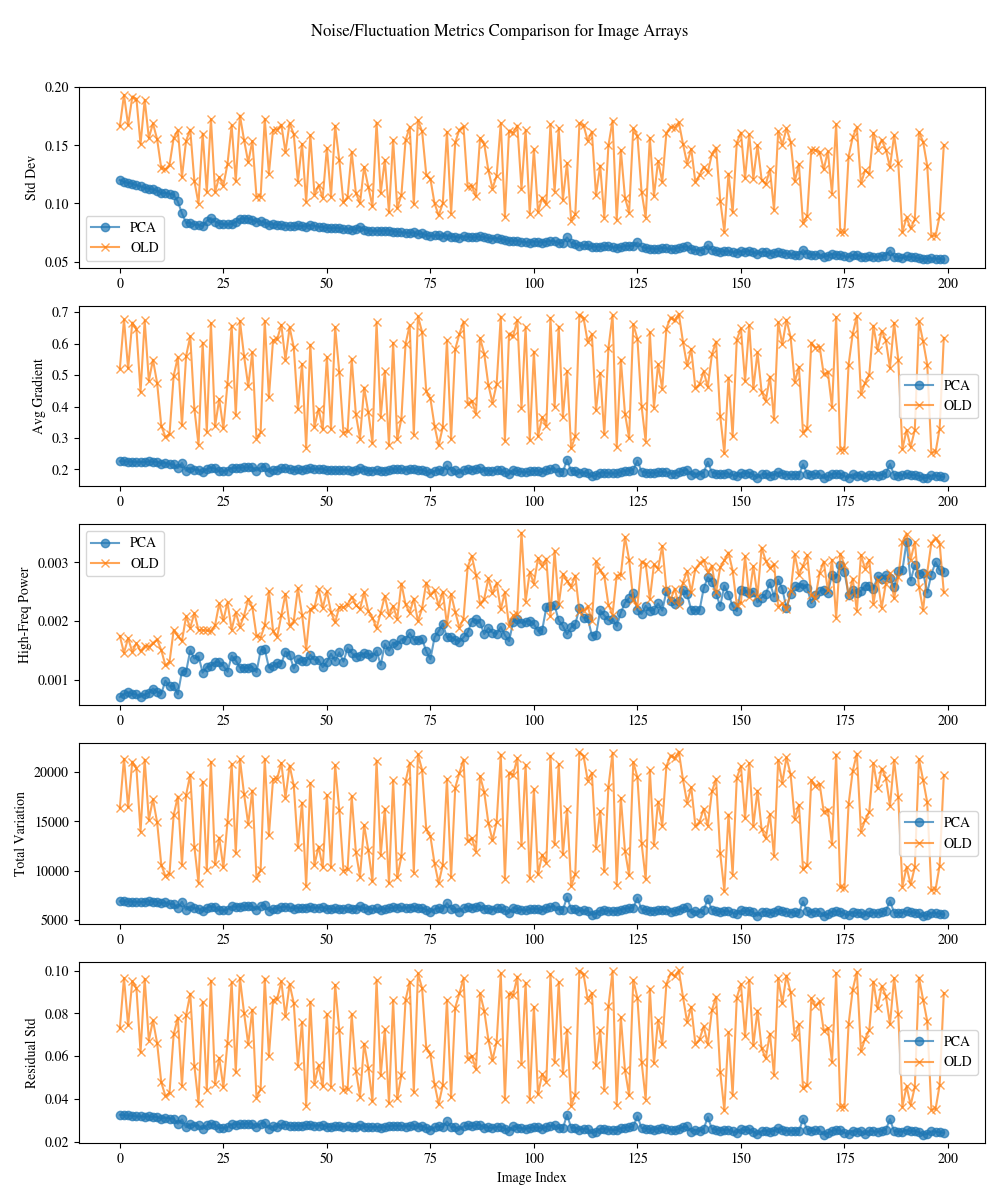

In [401]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel, gaussian_filter
from numpy.fft import fft2, fftshift

# --- Helper Functions ---
def high_freq_power(image, threshold=0.25):
    f = fftshift(fft2(image))
    mag = np.abs(f)**2
    h, w = image.shape
    cy, cx = h//2, w//2
    Y, X = np.ogrid[:h, :w]
    R = np.sqrt((Y-cy)**2 + (X-cx)**2)
    mask = R > threshold * np.sqrt((h//2)**2 + (w//2)**2)
    return np.sum(mag[mask]) / np.sum(mag)

def compute_metrics(image):
    std_dev = np.std(image)
    grad_mag = np.mean(np.hypot(sobel(image, axis=1), sobel(image, axis=0)))
    hf_power = high_freq_power(image)
    tv = np.sum(np.abs(np.diff(image, axis=0))) + np.sum(np.abs(np.diff(image, axis=1)))
    smooth = gaussian_filter(image, sigma=2)
    residual_std = np.std(image - smooth)
    return std_dev, grad_mag, hf_power, tv, residual_std

# Array 1: Low noise
array1 = all_residuals
array2 = all_angs_olds

# --- Compute metrics ---
metrics1 = np.array([compute_metrics(im) for im in array1])
metrics2 = np.array([compute_metrics(im) for im in array2])
labels = ['Std Dev', 'Avg Gradient', 'High-Freq Power', 'Total Variation', 'Residual Std']

# --- Plot metrics ---
fig, axs = plt.subplots(len(labels), 1, figsize=(10, 12))
for i, label in enumerate(labels):
    axs[i].plot(metrics1[:, i], label='PCA', marker='o', alpha=0.7)
    axs[i].plot(metrics2[:, i], label='OLD', marker='x', alpha=0.7)
    axs[i].set_ylabel(label)
    axs[i].legend()

axs[-1].set_xlabel('Image Index')
plt.suptitle("Noise/Fluctuation Metrics Comparison for Image Arrays")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


- Standard Deviation – overall pixel variability.
- Average Gradient Magnitude – local spatial fluctuations.
- High-Frequency Power – energy in sharp features or fine noise.
- Total Variation – sum of all absolute pixel differences.
- Residual Std – deviation from a smoothed version (texture-like noise).

## Spin 

In [478]:
# for t in range(number_of_images):
# --- Compare reconstruction ---
t       = 1      # test image index
pol_ch  = 0       # 0 or 1, for polarization 
V       = 12      # Number of PCA components to kee p
coeff = Vh[:V] @ stacks[1][t]
sim = coeff @ VHY[:V]
sim = sim.reshape(xdim, ydim)
residual = [ats[t, pc] - sim for pc in [0, 1]]

1


In [ ]:
# single line for all 

In [488]:
residual = np.array([[ats[t, pc] - ((Vh[:V] @ stacks[1][t]) @ VHY[:V]).reshape(xdim, ydim) for pc in [0, 1]] for t in range(number_of_images)])

<IPython.core.display.Javascript object>


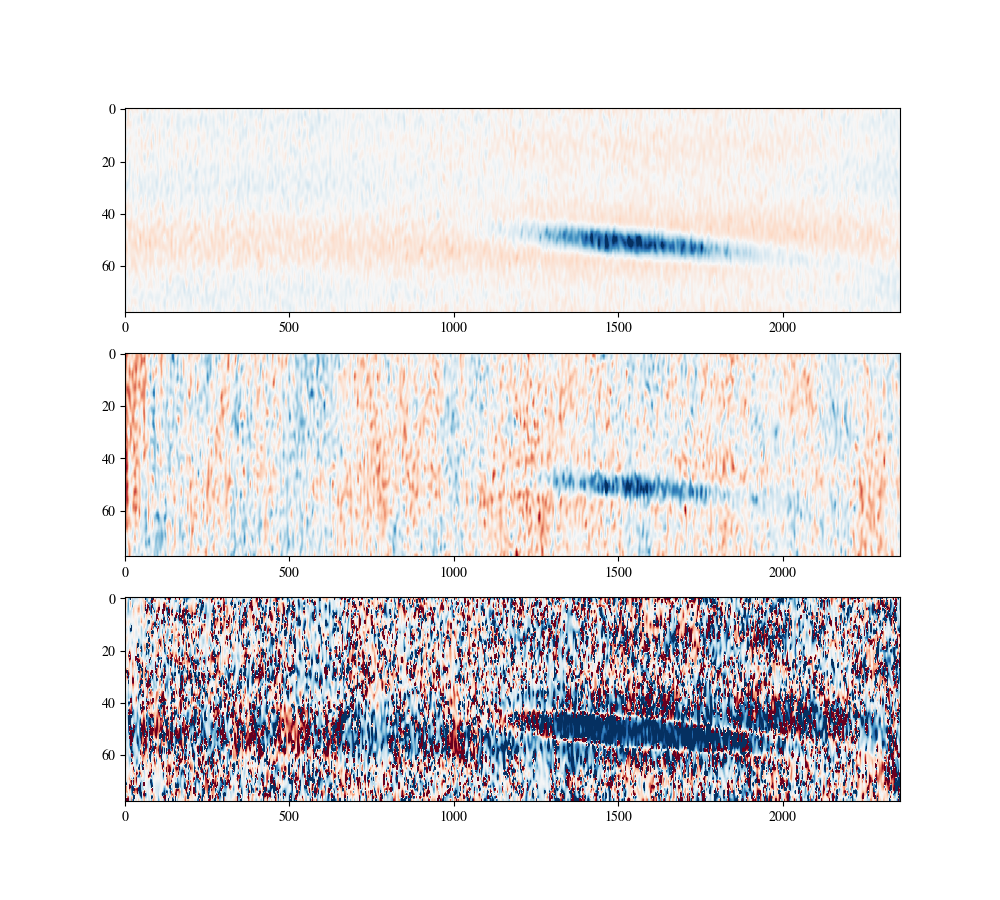

In [495]:
t = 3
fig, ax = plt.subplots(3, 1, figsize=(10, 9))
ax[0].imshow(residual[t][0], vmin=-1, vmax=1, cmap='RdBu', aspect='auto')
ax[1].imshow(residual[t][1], vmin=-1, vmax=1, cmap='RdBu', aspect='auto')
ax[2].imshow(residual[t][0] / residual[0][1], vmin=-1, vmax=1, cmap='RdBu', aspect='auto')
plt.show()

In [483]:
np.array(residual).shape

(2, 78, 2358)

In [ ]:
# for t in range(number_of_images):
# --- Compare reconstruction ---
t       = 1      # test image index
pol_ch  = 0       # 0 or 1, for polarization 
V       = 12      # Number of PCA components to kee p
print(t)
coeff = Vh[:V] @ stacks[1][t]
sim = coeff @ VHY[:V]
sim = sim.reshape(xdim, ydim)
residual = ats[t, pol_ch] - sim

at_ang = ats[t, pol_ch]
fl_ang = fls[t, pol_ch]
an_ang = phs[t, pol_ch]

# --- Plot ---
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 3, 3])

# PCA
ax01 = fig.add_subplot(gs[0, 0])
ax02 = fig.add_subplot(gs[0, 1], sharex=ax01, sharey=ax01)
ax03 = fig.add_subplot(gs[0, 2], sharex=ax01, sharey=ax01)
# OLD 
ax11 = fig.add_subplot(gs[1, 0], sharex=ax01, sharey=ax01)
ax12 = fig.add_subplot(gs[1, 1], sharex=ax01, sharey=ax01)
ax13 = fig.add_subplot(gs[1, 2], sharex=ax01, sharey=ax01)
# Linecuts
ax4 = fig.add_subplot(gs[2, :])
ax5 = fig.add_subplot(gs[3, :])

ax01.set_title('Raw Atoms')
ax02.set_title('Reconstructed Background')
ax03.set_title('Reconstructed Atoms')
ax01.set_ylabel("PCA")
ax11.set_ylabel("Old Method")

ax01.imshow(  at_ang, vmin=-1, vmax=1, cmap='RdBu', aspect='auto')  # Raw phase
ax02.imshow(     sim, vmin=-1, vmax=1, cmap='RdBu', aspect='auto')  # Reconstructed background
ax03.imshow(residual, vmin=-1, vmax=1, cmap='RdBu', aspect='auto')  # Residual (atoms only)
ax11.imshow(  at_ang, vmin=-1, vmax=1, cmap='RdBu', aspect='auto')  # Raw phase
ax12.imshow(  fl_ang, vmin=-1, vmax=1, cmap='RdBu', aspect='auto')  # Reconstructed background
ax13.imshow(  an_ang, vmin=-1, vmax=1, cmap='RdBu', aspect='auto')  # Old Phase Reconstruction 

# Linecuts
x_line = 1500
y_line = 52
ax4.set_title('Vertical Lineout Comparison')
ax5.set_title('Horizontal Lineout Comparison')

ax4.plot(residual[:, x_line], label='PCA', alpha=0.31, c='C0')
ax4.plot(   an_ang[:,x_line], label='OLD', alpha=0.31, c='C1')
ax5.plot(   residual[y_line], label='PCA', alpha=0.31, c='C0')
ax5.plot(     an_ang[y_line], label='OLD', alpha=0.31, c='C1')
ax4.legend(loc=1)
ax5.legend(loc=1)

for ax in [ax01, ax02, ax03, ax11, ax12, ax13]:
    ax.set_yticks([])
    ax.set_xticks([])

plt.suptitle(f"{date} - {shot} - {t}")
plt.tight_layout()
#     os.makedirs(f"/home/bec_lab/Desktop/imgs/SOAH/PCA_Analysis/images/PCA_vs_OLD/{date}_{shot}/", exist_ok=True)
#     plt.savefig(f"/home/bec_lab/Desktop/imgs/SOAH/PCA_Analysis/images/PCA_vs_OLD/{date}_{shot}/{str(t).zfill(4)}.png")
plt.show()


## Save Data for Allard's PCA

In [ ]:
# Randomize the background, or even get the mean or something? 
def HI_save_complex(date, shot, num, dz_focus, quad="quad1", num_flat=0, shift_pix=[0, 0], output="ang", filetype="atoms", plot=False, cut=[xmin, xmax, zmin, zmax]):
    """
    Main function for generating the output arrays for the holgoraphic imaging, which also includes the refocusing.
    What we do, is we process image - first take a FTT, apply Tukey windows, shift, refocus, and back iFFT.
    ------
    :param date: Input date of the image to be analysed
    :param shot: Input shot of the image to be analysed
    :param num: Input sequence number of the image to be analysed
    :param dz_focus: The focus parameter that determines the focus of the image
    :param quad: Parameter to determine which quad we are cutting.
    :param output: Output the phase (ang) or amplituide (amp)
    :param plot: Boolean to specify whether to plot the image of the angle or not. Better not when used in a loop.
    :return: Returns an array of the angle of the ratio of the iFFT's of the atom and flat image.
    """
    # ------------------------------------------------- IMPORTS -----------------------------------------------------
    path = '/storage/data/' + str(date) + '/'
    image = str(shot).zfill(4) + '/'
    
    xmin, xmax, zmin, zmax = cut

    if num != 0: 
        num_flat = num_flat % num 
        
    # Opening files
    if filetype == "atoms":
        atoms = pyfits.open(path + image + '0.fits')[0].data.astype(float)[num][xmin:xmax, zmin:zmax]
    
    elif filetype == "flat":
        atoms = pyfits.open(path + image + '1.fits')[0].data.astype(float)[num][xmin:xmax, zmin:zmax]

    dark = pyfits.open(path + image + '2.fits')[0].data.astype(float).mean(axis=0)[xmin:xmax, zmin:zmax]

    # ----------------------------------------------- CORRECTIONS ---------------------------------------------------
    # Creates a squaroid dark edge
    atoms = f1.squaroid(atoms - dark, width=0.51)
    # --------------------------------------------------- FFT --------------------------------------------------------
    # Take the FTT of the atoms
    fft_atoms = np.fft.fft2(atoms)
    quad1cut, q1peak = f1.box_cutter_pad_ellips(fft_atoms, quad, 0, 0, edge_x=10, edge_z=80)
    
    # ------------------------------------------------ FFT SHIFT ----------------------------------------------------
    # Now we FFT shift the zero frequency to the center
    fft1 = np.fft.fftshift(quad1cut)

    
    # ------------------------------------------------ PHASE SHIFT & FFT SHIFT ----------------------------------------------------
    # Shift in real space = linear phase in FFT space (optional)
    shift_x, shift_z = shift_pix

    Nz, Nx = quad1cut.shape  # Shape is (z, x)
    kx = np.fft.fftfreq(Nx)  # Now in cycles per pixel
    kz = np.fft.fftfreq(Nz)
    KX, KZ = np.meshgrid(kx, kz)         # Create full 2D grid

    # Linear phase ramp
    phase_ramp = np.exp(-1j * 2 * np.pi * (KX * shift_x + KZ * shift_z))

    # ------------------------------------------------ REFOCUSING ---------------------------------------------------
    fft_kx = np.fft.fftfreq(fft1.shape[1], d=pix_size)  # Discrete FFT Sample Frequency in x
    fft_ky = np.fft.fftfreq(fft1.shape[0], d=pix_size)  # Discrete FFT Sample Frequency in z
    fft_k2 = fft_kx[None, :] ** 2 + fft_ky[:, None] ** 2  # Discrete FFT Sample Frequency in main axes multiplied
    focus = np.exp(-1j * fft_k2 * dz_focus / (2 * k0))
    fft1 = fft1 * focus * phase_ramp

    # ------------------------------------- INVERSE FFT -------------------------------------------------
    inv1 = np.fft.ifft2(fft1) #/ np.fft.ifft2(flatfft1)

    return inv1

In [ ]:
date = 20250507
shot = 67
num_of_nums = get_nr_of_atoms(date, shot)

for shot in [65, 67]:
    num_of_nums = get_nr_of_atoms(date, shot)
    for filetype in ["atoms", "flat"]: 
        ang_ful_complex = [[HI_save_complex(date, shot, num, dz_focus, num_flat=num, filetype=filetype, shift_pix=[0, shift_z], quad=q, output="ang")for q, shift_z in zip(["quad1", "quad2"], [0, -0.48])] for num in range(num_of_nums)]
        np.save(f"/home/bec_lab/Desktop/full_complex_field_{date}_{shot}_{filetype}", ang_ful_complex)


## Check Chebyshev Phase Gradient Removal 

In [436]:
# Randomize the background, or even get the mean or something? 
def HI_save_complex_preprocess(date, shot, num, dz_focus, quad="quad1", num_flat=0, shift_pix=[0, 0], output="ang", filetype="atoms", plot=False, cut=[xmin, xmax, zmin, zmax]):
    """
    Main function for generating the output arrays for the holgoraphic imaging, which also includes the refocusing.
    What we do, is we process image - first take a FTT, apply Tukey windows, shift, refocus, and back iFFT.
    ------
    :param date: Input date of the image to be analysed
    :param shot: Input shot of the image to be analysed
    :param num: Input sequence number of the image to be analysed
    :param dz_focus: The focus parameter that determines the focus of the image
    :param quad: Parameter to determine which quad we are cutting.
    :param output: Output the phase (ang) or amplituide (amp)
    :param plot: Boolean to specify whether to plot the image of the angle or not. Better not when used in a loop.
    :return: Returns an array of the angle of the ratio of the iFFT's of the atom and flat image.
    """
    # ------------------------------------------------- IMPORTS -----------------------------------------------------
    path = '/storage/data/' + str(date) + '/'
    image = str(shot).zfill(4) + '/'
    
    xmin, xmax, zmin, zmax = cut

    if num != 0: 
        num_flat = num_flat % num 
        
    # Opening files
    if filetype == "atoms":
        atoms = pyfits.open(path + image + '0.fits')[0].data.astype(float)[num][xmin:xmax, zmin:zmax]
    
    elif filetype == "flat":
        atoms = pyfits.open(path + image + '1.fits')[0].data.astype(float)[num][xmin:xmax, zmin:zmax]

    #flat = pyfits.open(path + image + '1.fits')[0].data.astype(float)[num_flat][xmin:xmax, zmin:zmax]
    dark = pyfits.open(path + image + '2.fits')[0].data.astype(float).mean(axis=0)[xmin:xmax, zmin:zmax]

    # ----------------------------------------------- CORRECTIONS ---------------------------------------------------
    # Creates a squaroid dark edge
    atoms = f1.squaroid(atoms - dark, width=0.51)
    #flat = f1.squaroid(flat - dark, width=0.51)
    # --------------------------------------------------- FFT --------------------------------------------------------
    # Take the FTT of the atoms
    fft_atoms = np.fft.fft2(atoms)
    #fft_flat = np.fft.fft2(flat)

    # We create the Tukey windows cutouts for the data and the background. Additional cuts in x,z direction can be
    # passed, but this is optional; the default value is 0. Note that because you later cut everything in the
    # same size, this may affect the rest too.
    quad1cut, q1peak = f1.box_cutter_pad_ellips(fft_atoms, quad, 0, 0, edge_x=10, edge_z=80)
    #flatq1, f1peak = f1.box_cutter_pad_ellips(fft_flat, quad, 0, 0, edge_x=10, edge_z=80) #indices=q1peak)
    
    # Cutting the quads in the same sizes.
    #quad1cut, flatq1cut = f1.sizecomp(quad1, flatq1)

    # ------------------------------------------------ FFT SHIFT ----------------------------------------------------
    # Now we FFT shift the zero frequency to the center
    fft1 = np.fft.fftshift(quad1cut)
    #flatfft1 = np.fft.fftshift(flatq1cut)

    
    # ------------------------------------------------ PHASE SHIFT & FFT SHIFT ----------------------------------------------------
    # Shift in real space = linear phase in FFT space (optional)
    shift_x, shift_z = shift_pix

    Nz, Nx = quad1cut.shape  # Shape is (z, x)
    kx = np.fft.fftfreq(Nx)  # Now in cycles per pixel
    kz = np.fft.fftfreq(Nz)
    KX, KZ = np.meshgrid(kx, kz)         # Create full 2D grid

    # Linear phase ramp
    phase_ramp = np.exp(-1j * 2 * np.pi * (KX * shift_x + KZ * shift_z))

#     # Apply ramp before shifting
#     fft1 = np.fft.fftshift(quad1cut * phase_ramp)
#     flatfft1 = np.fft.fftshift(flatq1cut * phase_ramp)

    
    # ------------------------------------------------ REFOCUSING ---------------------------------------------------
    fft_kx = np.fft.fftfreq(fft1.shape[1], d=pix_size)  # Discrete FFT Sample Frequency in x
    fft_ky = np.fft.fftfreq(fft1.shape[0], d=pix_size)  # Discrete FFT Sample Frequency in z
    fft_k2 = fft_kx[None, :] ** 2 + fft_ky[:, None] ** 2  # Discrete FFT Sample Frequency in main axes multiplied

    # Determine the focus factor and refocus
    focus = np.exp(-1j * fft_k2 * dz_focus / (2 * k0))
    fft1 = fft1 * focus * phase_ramp
    #flatfft1 = flatfft1 * focus * phase_ramp


    # ------------------------------------- INVERSE FFT -------------------------------------------------
    inv1 = np.fft.ifft2(fft1) #/ np.fft.ifft2(flatfft1)

    return inv1



def RemovePhaseGradient_test(image, gradientremovalorder_X=3, gradientremovalorder_Y=2):
    image_unwrapped = unwrap_phase(np.angle(image))
    xdim_, ydim_ = image.shape
    X_axis = np.linspace(-1, 1, xdim_)
    Y_axis = np.linspace(-1, 1, ydim_)
    flat1 = np.mean(image_unwrapped, axis=0)
    flat2 = np.mean(image_unwrapped, axis=1)
    fit1 = cheb.chebfit(Y_axis, flat1, gradientremovalorder_Y)
    fit2 = cheb.chebfit(X_axis, flat2, gradientremovalorder_X)
    fit2[0] = 0
    fiteval = cheb.chebval(Y_axis, fit1) + np.outer(np.ones_like(Y_axis), cheb.chebval(X_axis, fit2)).T
    return np.exp(-1j * fiteval) * image


In [459]:
at_single = [HI_save_complex_preprocess(date, shot, 0, 0.000, quad="quad1", num_flat=0, shift_pix=[0, 0], output="ang", filetype=ft) for ft in ['atoms', 'flat']]

Using the new box cutter
------ r='quad1' ------
(array([30]), array([297]))
Using the new box cutter
------ r='quad1' ------
(array([30]), array([295]))


In [476]:
mtrx_size = 5
all_lcs = []
fig, ax = plt.subplots(5, 5, figsize=(13, 7), sharex=True, sharey=True)
for col in range(5):
    for row in range(5):
        ang_at = unwrap_phase(np.angle(RemovePhaseGradient_test(at_single[0][10:-10, 10:-10], gradientremovalorder_X=col, gradientremovalorder_Y=row+1)))
        ang_fl = unwrap_phase(np.angle(RemovePhaseGradient_test(at_single[1][10:-10, 10:-10], gradientremovalorder_X=col, gradientremovalorder_Y=row+1)))
        ax[col][row].imshow(ang_at - ang_fl, vmin=-1, vmax=1, cmap='RdBu', aspect='auto')
        ax[col][0].set_ylabel(f"{col+1}")
        ax[0][row].set_title(f"{row+1}")
        ax[col][row].set_yticks([])
        ax[col][row].set_xticks([])
        all_lcs.append((ang_at-ang_fl)[52])
plt.show()

<IPython.core.display.Javascript object>

In [477]:
plt.figure()
plt.plot(np.array(all_lcs).T)
plt.show()

<IPython.core.display.Javascript object>